In [24]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfd

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

## Prepare the dataset

In [25]:
dataset = tfd.load('mnist', as_supervised=True)
mnist_train, mnist_test = dataset['train'], dataset['test']

In [26]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5 # Normalize the images to [-1, 1]
    return image

In [27]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [28]:
train_dataset = mnist_train.map(convert_types).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

In [29]:
def make_generator():
    model = tfk.Sequential()
    model.add(tfk.layers.Dense(7*7*BATCH_SIZE, use_bias=False, input_shape=(100,)))
    model.add(tfk.layers.BatchNormalization())
    model.add(tfk.layers.LeakyReLU())
    
    model.add(tfk.layers.Reshape((7, 7, BATCH_SIZE)))
    assert model.output_shape == (None, 7, 7, BATCH_SIZE)
    
    model.add(tfk.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tfk.layers.BatchNormalization())
    model.add(tfk.layers.LeakyReLU())
    
    model.add(tfk.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tfk.layers.BatchNormalization())
    model.add(tfk.layers.LeakyReLU())
    
    model.add(tfk.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [7]:
generator = make_generator()

In [8]:
z = tf.random.normal([1, 100])

In [9]:
x_fake = generator(z, training=False)

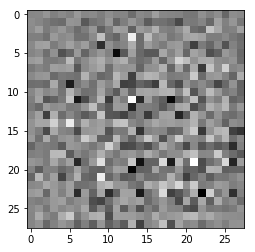

In [10]:
# plot gpu tensor directly using matplotlib
# without being converted into a CPU tensor
plt.imshow(x_fake[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator():
    model = tfk.Sequential()
    model.add(tfk.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))                                
    model.add(tfk.layers.LeakyReLU())
    model.add(tfk.layers.Dropout(0.3))
    
    model.add(tfk.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tfk.layers.LeakyReLU())
    model.add(tfk.layers.Dropout(0.3))
    
    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(1))
    
    return model

In [12]:
discriminator = make_discriminator()

In [13]:
p = discriminator(x_fake)
print(p)

tf.Tensor([[0.00299966]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [14]:
cross_entropy = tfk.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

$$\mathrm{minimize} -\mathbb{E}_{x \sim \mathbb{P}_{\mathrm data}}[\log D(x)] 
   -\mathbb{E}_{x \sim \mathbb{P}_{\mathrm generated}}[\log(1 - D(x))]$$
   
Discriminator labels $x \sim \mathbb{P}_{\mathrm data}$ with $y = 1$ and labels $x \sim \mathbb{P}_{\mathrm generated}$ with $y = 0$. The first term corresponds to the binary cross entropy loss of $y=1$ and the second term corresponds to the binary cross entropy loss of $y=0$. 

In [15]:
def discriminator_loss(output_real, output_fake):
    loss_real = cross_entropy(tf.ones_like(output_real), output_real)
    loss_fake = cross_entropy(tf.zeros_like(output_fake), output_fake)
    return loss_real + loss_fake

### Generator loss

$$\mathrm{minimize} -\mathbb{E}_{x \sim \mathbb{P}_{\mathrm generated}}[\log D(x)]$$

Generator labels $x \sim \mathbb{P}_{\mathrm generated}$ with $y = 1$.

In [16]:
def generator_loss(output_fake):
    return cross_entropy(tf.ones_like(output_fake), output_fake)

In [17]:
generator_optimizer = tfk.optimizers.Adam(1e-4)
discriminator_optimizer = tfk.optimizers.Adam(1e-4)

## Define the training loop

In [18]:
checkpoint_dir = '/tmp/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
@tf.function
def train_step(x_real):
    z = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        x_fake = generator(z, training=True)
        
        output_real = discriminator(x_real, training=True)
        output_fake = discriminator(x_fake, training=True)
        
        gen_loss = generator_loss(output_fake)
        disc_loss = discriminator_loss(output_real, output_fake)
        
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))


In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for x in dataset:
            train_step(x)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print("Time for epoch {} is {} sec".format(epoch+1, time.time()-start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [22]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

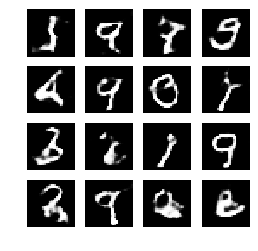

CPU times: user 17min 31s, sys: 4min 20s, total: 21min 52s
Wall time: 10min 21s


In [23]:
%%time
train(train_dataset, EPOCHS)